In [285]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    'Num cells x0.125': load_data('../stats/fpm_4_simplices_x0.5.json'),
    'Num cells x1': load_data('../stats/fpm_4_simplices_x1.json'),
# #     # 'num cells x64': load_data('../stats/fpm_3_x4.json'),
    # 'Num cells x8': load_data('../stats/fpm_4_x2.json'),
# #     # 'num cells x125': load_data('../stats/fpm_3_x5.json'),
    # 'Num cells x27': load_data('../stats/fpm_4_x3.json'),
# #     # 'num cells x216': load_data('../stats/fpm_3_x6.json'),
}

In [286]:
shape = [2, 1]
figsize = (7, 4)

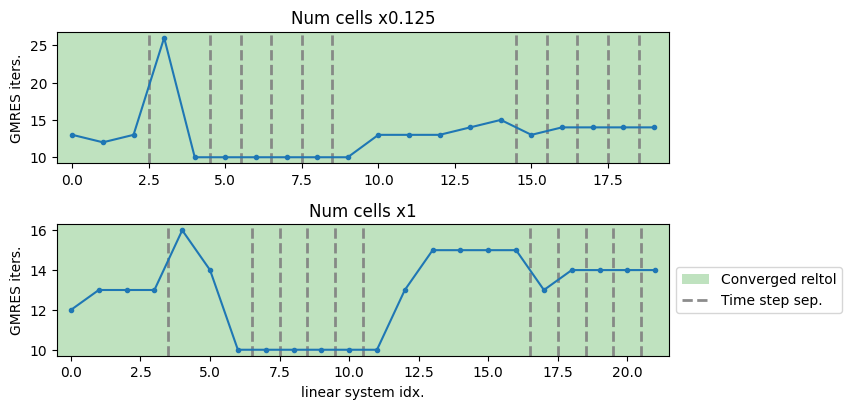

In [287]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

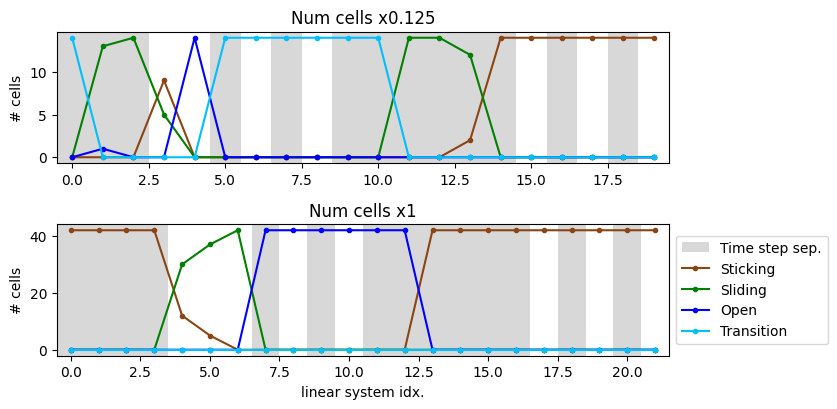

In [288]:
def render_element(entry: Sequence[TimeStepStats]):
    st, sl, op, tr = get_num_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.plot(st, label='Sticking', marker='.', color=COLOR_STICKING)
    plt.plot(sl, label='Sliding', marker='.', color=COLOR_SLIDING)
    plt.plot(op, label='Open', marker='.', color=COLOR_OPEN)
    plt.plot(tr, label='Transition', marker='.', color=COLOR_TRANSITION)

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# cells')

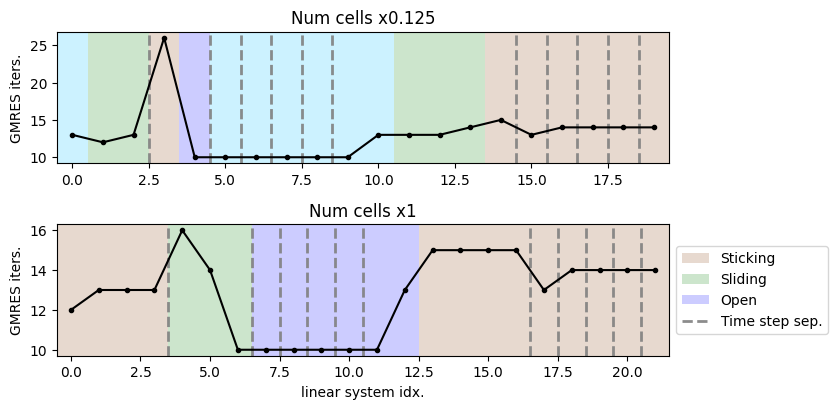

In [289]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')
    # plt.ylim(top=21)

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

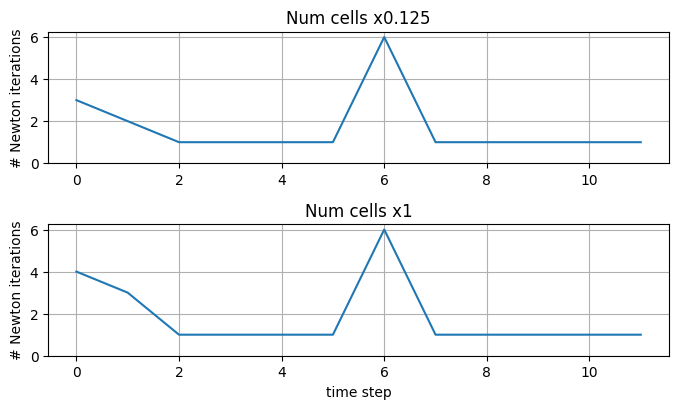

In [290]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step', legend=False)

# Testing bad matrix

In [291]:
assert False

AssertionError: 

In [292]:
from fpm_4_simplices import make_model

entry = data['Num cells x0.125']

model = make_model()
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()



num sticking: 0
num sliding: 0
num open: 0
num trans: 14


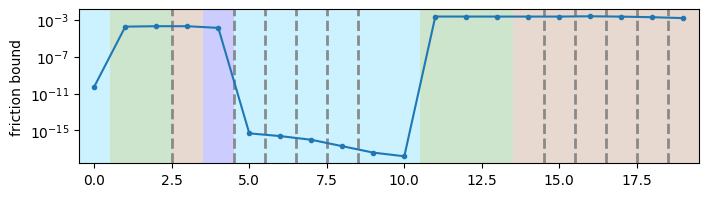

In [293]:
plt.figure(figsize=(8, 2))
color_sticking_sliding_open_transition(entry)
color_time_steps(entry, fill=False, legend=True)
plt.gca().grid(False)
plt.plot(get_friction_bound_norm(model, entry), marker='.')
plt.ylabel('friction bound')
plt.yscale('log')

In [307]:
mat_idx = 3
entry = data['Num cells x0.125']
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

26


In [308]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)
model.ad_time_step.set_value(dt)

st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

model.assemble_linear_system()
perm_mat, prec_orig = model._prepare_solver()
J = perm_mat[:]

9
5
0
0


In [309]:
fractures = model.mdg.subdomains(dim=model.nd - 1)
tmp = model.tangential_fracture_deformation_equation(fractures)
jac = tmp.value_and_jacobian(model.equation_system).jac
jac

lambda_dofs = model.equation_system.dofs_of([model.contact_traction_variable])
jac[:, lambda_dofs]

u_intf_dofs = model.equation_system.dofs_of([model.interface_displacement_variable])
jac[:, u_intf_dofs]

<28x84 sparse matrix of type '<class 'numpy.float64'>'
	with 76 stored elements in Compressed Sparse Row format>

Solve  took: 1.58
True residual decrease: 761767.437788689
PETSc Converged Reason: -5
lambda min: 1.471590162096126


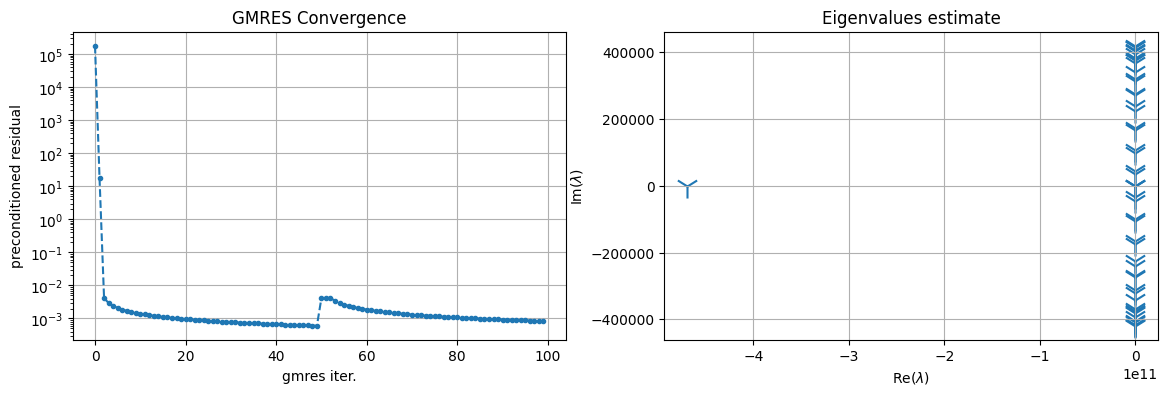

In [310]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

Solve  took: 0.72
True residual decrease: 129.23453943695552
PETSc Converged Reason: -5
lambda min: 0.552435813999923


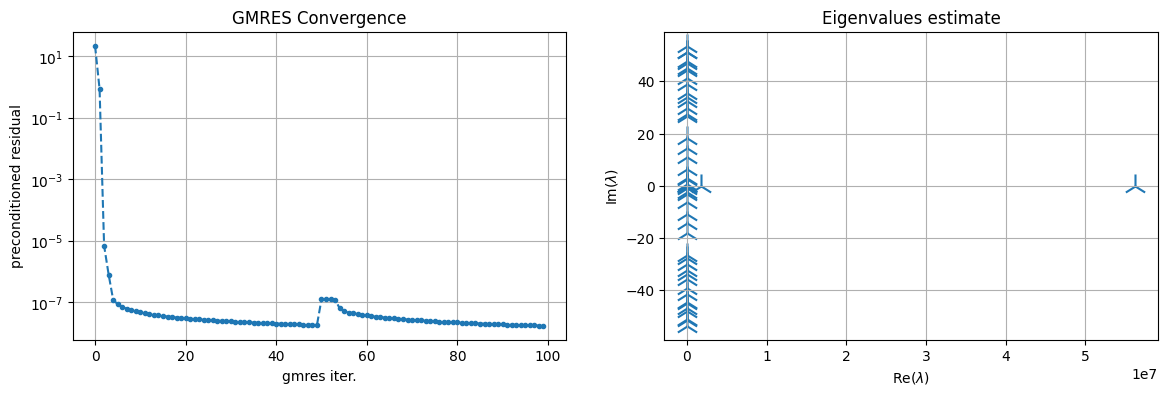

In [311]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_fs

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv_bdiag(model, bmat=bmat),
    complement=SolveSchema(
        # groups=[3],
        # solve=lambda bmat: PetscILU(bmat[[3]].mat),
        # invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            # invertor=lambda bmat: make_fs(model, bmat).mat,
            # invertor=lambda bmat: model._fixed_stress.mat,
            # invertor_type="physical",
            # complement=SolveSchema(
            #     groups=[0, 2],
            #     solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            # ),
        # ),
    ),
)

bmat_reordered, preconditioner = make_solver(schema=schema, mat_orig=J)
solve_petsc(bmat_reordered.mat, preconditioner, rhs=bmat_reordered.local_rhs(rhs))

In [341]:
bmat = J
J44 = bmat[4,4].mat
J55 = bmat[5,5].mat
# J55_inv = inv_block_diag(J55, nd=model.nd)
J55_inv = inv(J55)
stab = bmat[4, 5].mat @ J55_inv @ bmat[5, 4].mat
st, sl, op, tr = model.sticking_sliding_open_transition()

sliding_tang = np.repeat(sl, model.nd)
# sliding_tang[::model.nd] = 0  # we need only tangential
# stab[sliding_tang] = 0

sliding_norm = np.repeat(sl, model.nd)
# sliding_norm[1::model.nd] = 0
# sliding_norm[2::model.nd] = 0

# stab[sliding_norm, 0::3] = 0
# stab[sliding_norm, 1::3] = 0

S44 = J44 - stab

In [342]:
np.where(sl)

(array([0, 1, 6, 7, 9]),)

In [343]:
i = 6
J44[i*3:(i+1) * 3, i*3:(i+1) * 3].A

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.78037555e-05, -8.55679753e-07,  1.59599277e-05],
       [-8.55679753e-07, -1.83290980e-07,  4.93963636e-07]])

In [344]:
stab[i*3:(i+1) * 3, i*3:(i+1) * 3].A

array([[-5.49777745e+00, -2.13660314e+00, -6.13913072e+01],
       [-1.45736170e-05, -1.03434396e-04, -9.21867309e-07],
       [-8.14979559e-05,  3.32103066e-03,  4.98752637e-05]])

In [334]:
S44[i*3:(i+1) * 3, i*3:(i+1) * 3].A

array([[ 5.49777745e+00,  2.13660314e+00,  6.13913072e+01],
       [-2.78037555e-05, -8.55679753e-07,  1.59599277e-05],
       [-8.55679753e-07, -1.83290980e-07,  4.93963636e-07]])

In [335]:
J45 = J[[4, 5]].copy().mat
J45_stab = J[[4, 5]].copy()
J45_stab[4, 4] = S44

cond(inv(J45_stab.mat) @ J45)

2.8593424610443923

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


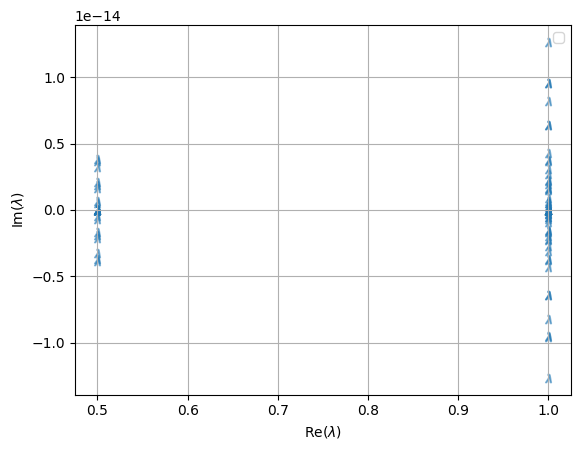

In [336]:
plot_eigs(inv(J45_stab.mat) @ J45)

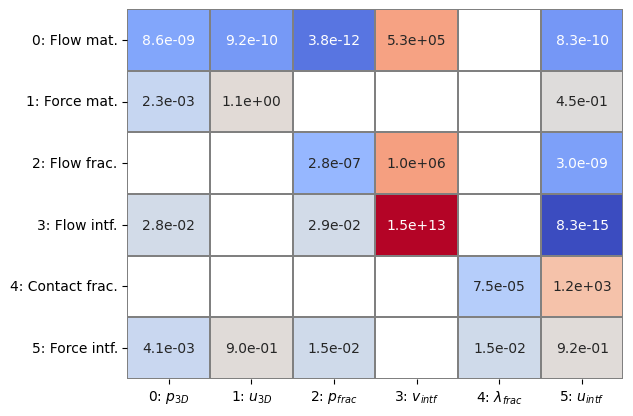

In [345]:
J.plot_max()

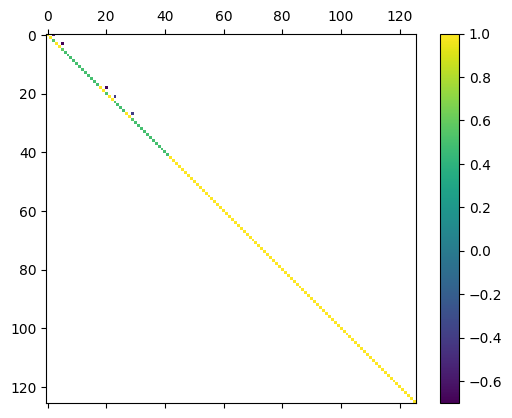

In [319]:
%matplotlib inline
plot_mat(inv(J45_stab.mat) @ J45, log=False, threshold=1e-1)

THERE ARE NEGATIVE ENTRIES IN THE MAIN DIAGONAL FOR THE BAD MATRIX #3

[3, 18] -> [1, 6]

In [338]:
np.where(sl)

(array([0, 1, 6, 7, 9]),)

In [337]:
approx_I = inv(J45_stab.mat) @ J45
approx_I.diagonal()

array([0.91023787, 0.99994959, 0.58976459, 0.86912184, 0.99985962,
       0.63115488, 0.50000053, 0.49999986, 0.50000025, 0.50000002,
       0.5       , 0.50000003, 0.5       , 0.5       , 0.49999999,
       0.50000154, 0.49999984, 0.50000068, 0.94273036, 0.99971404,
       0.55765332, 0.93441242, 1.00029953, 0.56508617, 0.5000134 ,
       0.50000804, 0.49999998, 0.91689235, 0.99999211, 0.58299067,
       0.50000005, 0.5       , 0.5       , 0.49992298, 0.50015525,
       0.50003127, 0.49998408, 0.50001395, 0.50000848, 0.49999929,
       0.50000112, 0.50000002, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     